In [31]:
!pip install mlxtend
!pip install imbalanced-learn
!pip install itables
!pip install xgboost

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import plot_tree
from mlxtend.plotting import plot_decision_regions
import mlxtend
import sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier

In [32]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Colab Notebooks/Machine_learning_Tahlildadeh"


from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

df = pd.read_csv(f'{data_path}/diabetes.csv')
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(768, 9)

In [33]:
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [35]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [36]:
df['Outcome'].value_counts(normalize = True) * 100

Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64

In [37]:
missing_values = ['NA', 'N/A', 'missing', '', 'unknown','?']
for value in missing_values:
    df.replace(to_replace=value, value=np.nan, inplace=True)

In [38]:
df = df[(df['Insulin'] != 0) & (df['SkinThickness'] != 0)]

In [39]:

# Function to replace outliers using IQR method
def replace_outliers_iqr(df):
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64]:  # Only process numeric columns
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            upper_cap = Q3 + 1.5 * IQR
            lower_cap = Q1 - 1.5 * IQR

            # Replace values
            df[column] = np.where(df[column] > upper_cap, upper_cap, df[column])
            df[column] = np.where(df[column] < lower_cap, lower_cap, df[column])

    return df

# Separate the 'Outcome' column
outcome = df['Outcome']
cf = df.drop(columns=['Outcome'])

# Apply the function to remove outliers
cleaned_data = replace_outliers_iqr(cf)

# Add the 'Outcome' column back to the cleaned DataFrame
cleaned_data['Outcome'] = outcome

print(cleaned_data)
df = cleaned_data

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3            1.0     89.0           66.0           23.0   94.000  28.1   
4            0.0    137.0           40.0           35.0  168.000  43.1   
6            3.0     78.0           50.0           32.0   88.000  31.0   
8            2.0    197.0           70.0           45.0  360.625  30.5   
13           1.0    189.0           60.0           23.0  360.625  30.1   
..           ...      ...            ...            ...      ...   ...   
753          0.0    181.0           88.0           44.0  360.625  43.3   
755          1.0    128.0           88.0           39.0  110.000  36.5   
760          2.0     88.0           58.0           26.0   16.000  28.4   
763         10.0    101.0           76.0           48.0  180.000  32.9   
765          5.0    121.0           72.0           23.0  112.000  26.2   

     DiabetesPedigreeFunction   Age  Outcome  
3                    0.167000  21.0        0  
4                

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
# Separate the 'Outcome' column
outcome = df['Outcome']
cf = df.drop(columns=['Outcome'])

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cf)

# Optional: Reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 dimensions if necessary
reduced_features = pca.fit_transform(scaled_features)

# Apply DBSCAN
db = DBSCAN(eps=0.3, min_samples=2)  # Adjust eps and min_samples based on your data
dbscan_labels = db.fit_predict(reduced_features)

# Add the DBSCAN labels to the DataFrame
cf['outliers'] = dbscan_labels
print(cf['outliers'].value_counts())

# Calculate median values of non-outliers for each feature
median_values = cf[cf['outliers'] != -1].median()

# Replace outlier values with the median values
for column in cf.columns:
    if column != 'outliers':
        cf.loc[cf['outliers'] == -1, column] = median_values[column]

# Drop the 'outliers' column
cf_cleaned = cf.drop(columns=['outliers'])

# Add the 'Outcome' column back
cf_cleaned['Outcome'] = outcome

print("DataFrame after replacing outliers with median values and adding 'Outcome' column back:")
print(cf_cleaned)

df = cf_cleaned

outliers
 0     277
-1      25
 5      23
 2      13
 6      10
 1       8
 10      7
 15      5
 3       3
 4       3
 11      3
 12      3
 14      2
 16      2
 8       2
 13      2
 9       2
 7       2
 17      2
Name: count, dtype: int64
DataFrame after replacing outliers with median values and adding 'Outcome' column back:
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3            1.0     89.0           66.0           23.0   94.000  28.1   
4            0.0    137.0           40.0           35.0  168.000  43.1   
6            3.0     78.0           50.0           32.0   88.000  31.0   
8            2.0    197.0           70.0           45.0  360.625  30.5   
13           1.0    189.0           60.0           23.0  360.625  30.1   
..           ...      ...            ...            ...      ...   ...   
753          0.0    181.0           88.0           44.0  360.625  43.3   
755          1.0    128.0           88.0           39.0  110.000  36.5   
76

In [41]:
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3            1.0     89.0           66.0           23.0   94.000  28.1   
4            0.0    137.0           40.0           35.0  168.000  43.1   
6            3.0     78.0           50.0           32.0   88.000  31.0   
8            2.0    197.0           70.0           45.0  360.625  30.5   
13           1.0    189.0           60.0           23.0  360.625  30.1   
..           ...      ...            ...            ...      ...   ...   
753          0.0    181.0           88.0           44.0  360.625  43.3   
755          1.0    128.0           88.0           39.0  110.000  36.5   
760          2.0     88.0           58.0           26.0   16.000  28.4   
763         10.0    101.0           76.0           48.0  180.000  32.9   
765          5.0    121.0           72.0           23.0  112.000  26.2   

     DiabetesPedigreeFunction   Age  Outcome  
3                    0.167000  21.0        0  
4                    1.312125  33.0        1  
6                    0.248000  26.0        1  
8                    0.158000  53.0        1  
13                   0.398000  55.5        1  
..                        ...   ...      ...  
753                  0.222000  26.0        1  
755                  1.057000  37.0        1  
760                  0.766000  22.0        0  
763                  0.171000  55.5        0  
765                  0.245000  30.0        0  

[394 rows x 9 columns]

In [42]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   394.000000  394.000000     394.000000     394.000000  394.000000   
mean      3.058376  121.690355      70.421320      29.096447  144.411485   
std       2.886160   29.515434      11.652524       9.812016   85.591914   
min       0.000000   33.000000      38.000000       7.000000   16.000000   
25%       1.000000  100.000000      64.000000      22.000000   82.000000   
50%       2.000000  119.000000      70.000000      29.000000  125.000000   
75%       4.000000  139.000000      78.000000      35.750000  182.000000   
max      11.000000  198.000000     102.000000      60.000000  360.625000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  394.000000                394.000000  394.000000  394.000000  
mean    33.045685                  0.504062   29.889594    0.329949  
std      6.267144                  0.282713    8.850604    0.470792  
min     15.200000                  0.085000   21.000000    0.000000  
25%     28.725000                  0.284250   23.000000    0.000000  
50%     33.200000                  0.447000   27.000000    0.000000  
75%     36.600000                  0.671250   34.000000    1.000000  
max     50.200000                  1.312125   55.500000    1.000000

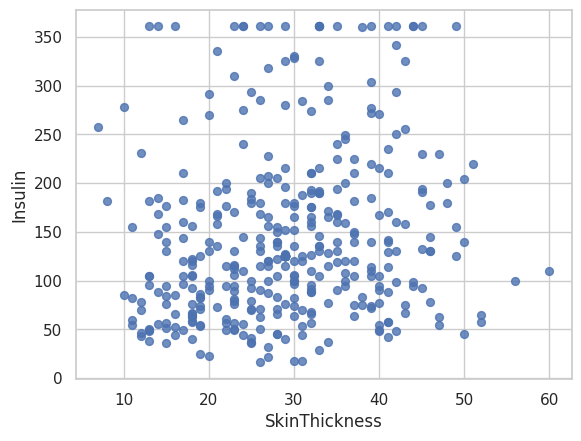

In [43]:
# @title SkinThickness vs Insulin

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='SkinThickness', y='Insulin', s=32, alpha=.8)
plt.show()

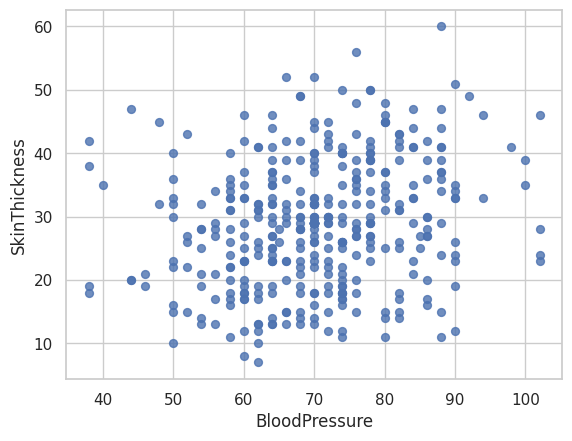

In [44]:
# @title BloodPressure vs SkinThickness

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='BloodPressure', y='SkinThickness', s=32, alpha=.8)
plt.show()

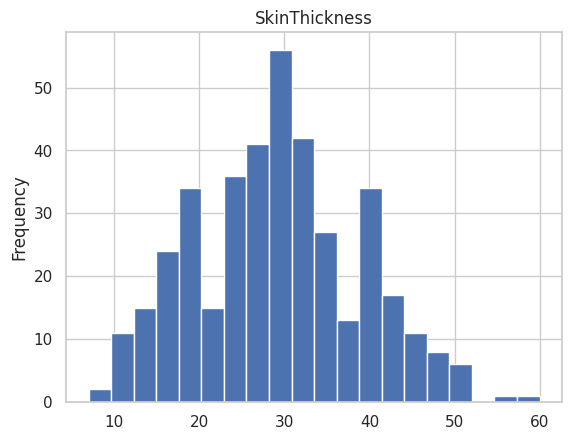

In [45]:
# @title SkinThickness

from matplotlib import pyplot as plt
df['SkinThickness'].plot(kind='hist', bins=20, title='SkinThickness')
plt.show()

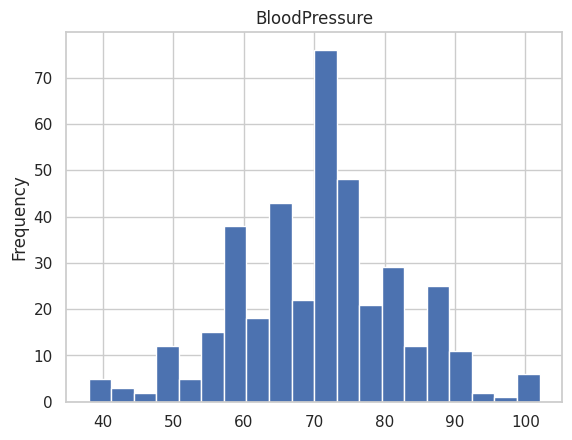

In [46]:
# @title BloodPressure

from matplotlib import pyplot as plt
df['BloodPressure'].plot(kind='hist', bins=20, title='BloodPressure')
plt.show()

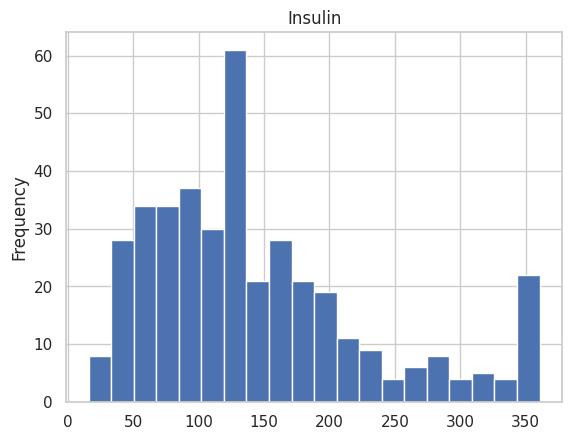

In [47]:
# @title BloodPressure

from matplotlib import pyplot as plt
df['Insulin'].plot(kind='hist', bins=20, title='Insulin')
plt.show()

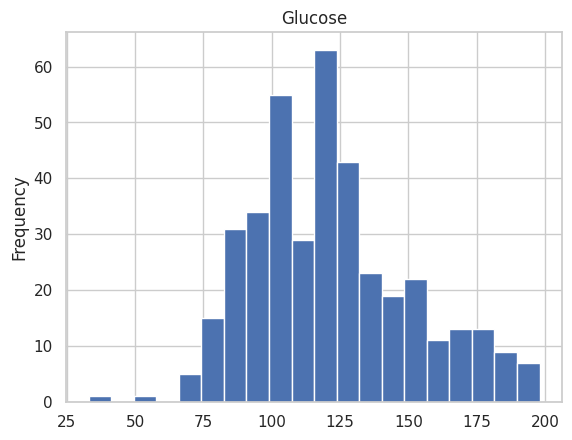

In [48]:
# @title Glucose

from matplotlib import pyplot as plt
df['Glucose'].plot(kind='hist', bins=20, title='Glucose')
plt.show()

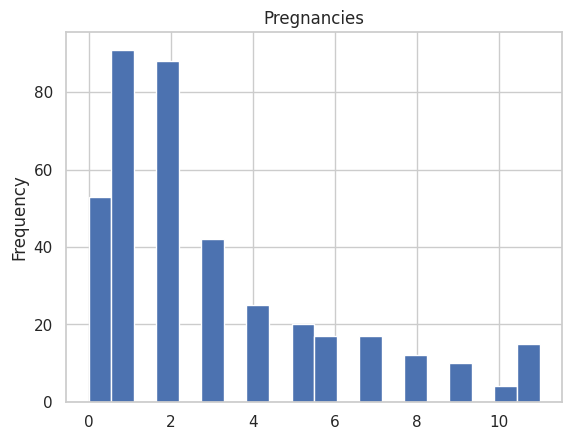

In [49]:
# @title Pregnancies

from matplotlib import pyplot as plt
df['Pregnancies'].plot(kind='hist', bins=20, title='Pregnancies')
plt.show()

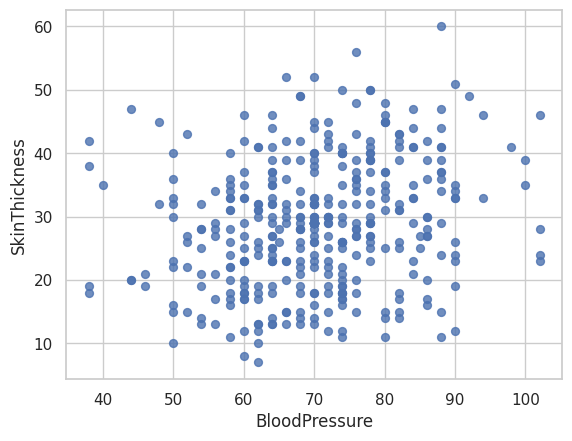

In [50]:
# @title BloodPressure vs SkinThickness

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='BloodPressure', y='SkinThickness', s=32, alpha=.8)
plt.show()

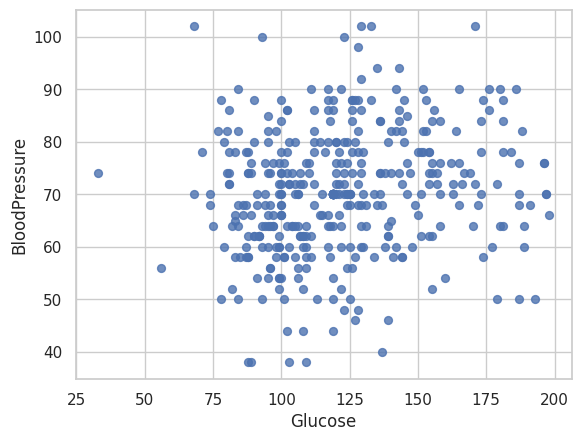

In [51]:
# @title Glucose vs BloodPressure

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Glucose', y='BloodPressure', s=32, alpha=.8)
plt.show()

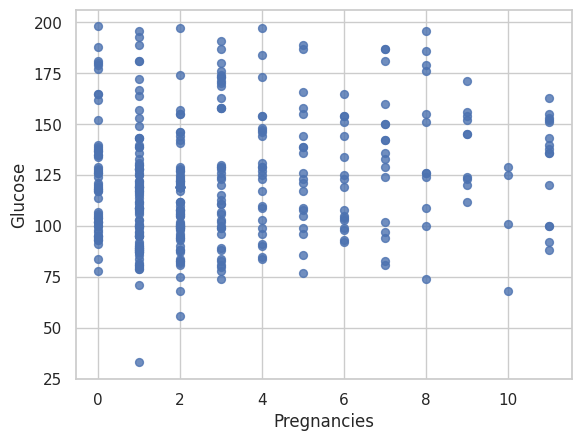

In [52]:
# @title Pregnancies vs Glucose

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Pregnancies', y='Glucose', s=32, alpha=.8)
plt.show()

In [53]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3           1.0     89.0           66.0           23.0   94.000  28.1   
4           0.0    137.0           40.0           35.0  168.000  43.1   
6           3.0     78.0           50.0           32.0   88.000  31.0   
8           2.0    197.0           70.0           45.0  360.625  30.5   
13          1.0    189.0           60.0           23.0  360.625  30.1   

    DiabetesPedigreeFunction   Age  Outcome  
3                   0.167000  21.0        0  
4                   1.312125  33.0        1  
6                   0.248000  26.0        1  
8                   0.158000  53.0        1  
13                  0.398000  55.5        1

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
# Set the style for the plots
sns.set(style="whitegrid")

# 1. Distribution of the Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribution of Outcome Variable')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

# 2. Correlation Matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 3. Feature Distributions
df.hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

# 4. Pair Plot
sns.pairplot(df, hue='Outcome', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot', fontsize=16)
plt.show()

# 5. Box Plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Outcome', y=column, data=df, palette='viridis')
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.